<a href="https://colab.research.google.com/github/Yagwar/ASAG_Test/blob/master/clasiff_eval_items_compare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Libraries

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use("seaborn")
import seaborn as sns
import pprint, pickle

from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from scipy.stats.stats import pearsonr
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
drive_path = 'gdrive/My Drive/maestria ucatolica/Proyecto de grado/Analisis/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Load data


In [0]:
train_questions=pd.read_csv(drive_path+"train_questions.csv", sep=";",index_col=0)
train_ref_ans=pd.read_csv(drive_path+"train_ref_ans.csv", sep=";",index_col=0)
train_stud_ans=pd.read_csv(drive_path+"train_stud_ans.csv", sep=";",index_col=0)
test_questions=pd.read_csv(drive_path+"test_questions.csv", sep=";",index_col=0)
test_ref_ans=pd.read_csv(drive_path+"test_ref_ans.csv", sep=";",index_col=0)
test_stud_ans=pd.read_csv(drive_path+"test_stud_ans.csv", sep=";",index_col=0)

train_answers=pd.read_csv(drive_path+"train_answers.csv", sep=";",index_col=0)
test_answers=pd.read_csv(drive_path+"test_answers.csv", sep=";",index_col=0)

In [0]:
test_divs=['TEST Beetle Unseen Answers',
           'TEST sciEntsBank Unseen Answers']
test_answers=test_answers[(test_answers['dtset'] == "TEST Beetle Unseen Answers") | (test_answers['dtset'] == "TEST sciEntsBank Unseen Answers")]

In [0]:
# complete_texts=pd.concat([train_questions.question,
#                           train_ref_ans.ref_ans,
#                           train_stud_ans.st_answ,
#                           test_questions.question,
#                           test_ref_ans.ref_ans,
#                           test_stud_ans.st_answ], 
#                          ignore_index=True)
train_texts=pd.concat([train_questions.question,
                       train_ref_ans.ref_ans,
                       train_stud_ans.st_answ],
                      ignore_index=True)
test_texts=pd.concat([test_questions.question,
                      test_ref_ans.ref_ans,
                      test_stud_ans.st_answ], 
                      ignore_index=True)

### Answers for diff mat

In [0]:
train_answers_items=pd.pivot_table(train_answers, values='st_ans_calif',index=train_answers.index, columns=['quest_id']);train_answers_items.to_csv(drive_path+"train_answers_items.csv")
test_answers_items=pd.pivot_table(test_answers, values='st_ans_calif',index=test_answers.index, columns=['quest_id']);test_answers_items.to_csv(drive_path+"test_answers_items.csv")

## Preprocessing

In [0]:
text_tfidf= Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer())
])

In [0]:
txt_tfidf=text_tfidf.fit(train_texts) #  Matriz tf-idf con textos de train solamente
# txt_tfidf=text_tfidf.fit(complete_texts) # Matriz tf-idf con textos de train y test

In [0]:
train_preg_ref_res_X=[]
for ith_ans in range(train_answers.st_answ.shape[0]):
    out_array=np.array([
        txt_tfidf.transform([train_answers.question[ith_ans]]).toarray()[0],
        txt_tfidf.transform([train_answers.ref_ans[ith_ans]]).toarray()[0],
        txt_tfidf.transform([train_answers.st_answ[ith_ans]]).toarray()[0]
    ]).ravel()
    train_preg_ref_res_X.append(out_array)
train_preg_ref_res_X=np.array(train_preg_ref_res_X)
train_preg_ref_res_y=train_answers.st_ans_calif

test_preg_ref_res_X=[]
for ith_ans in range(test_answers.st_answ.shape[0]):
    out_array=np.array([
        txt_tfidf.transform([test_answers.question.iloc[ith_ans]]).toarray()[0],
        txt_tfidf.transform([test_answers.ref_ans.iloc[ith_ans]]).toarray()[0],
        txt_tfidf.transform([test_answers.st_answ.iloc[ith_ans]]).toarray()[0]
    ]).ravel()
    test_preg_ref_res_X.append(out_array)
test_preg_ref_res_X=np.array(test_preg_ref_res_X)
test_preg_ref_res_y=test_answers.st_ans_calif

![Baselines](https://raw.githubusercontent.com/Yagwar/ASAG_Test/master/baselines.png)

## Classifiers

In [0]:
pkl_file = open(drive_path+'train_test_embeddings.pkl', 'rb')
train_preg_ref_res_X,train_preg_ref_res_y,test_preg_ref_res_X,test_preg_ref_res_y,embeddings_names = pickle.load(pkl_file)
pkl_file.close()

In [0]:
train_X=train_preg_ref_res_X;print(train_X.shape)
train_y=train_preg_ref_res_y;print(train_y.shape)
test_X=test_preg_ref_res_X;print(test_X.shape)
test_y=test_preg_ref_res_y;print(test_y.shape)

(22167, 8931)
(22167,)
(2402, 8931)
(2402,)


In [0]:
names = [
    "Nearest Neighbors", 
#     "Linear SVM", 
    "RBF SVM", 
#     "Gaussian Process",
#     "Decision Tree", 
    "Random Forest", 
#     "Neural Net", 
    "AdaBoost",
    "Naive Bayes", 
    "QDA"]

names_short = [
    "KNN", 
#     "L_SVM", 
    "RBF_SVM", 
#     "GaussSVM",
#     "Dec_Tree", 
    "Rand_Forest", 
#     "ANN", 
    "AdaBoost",
    "Naive_Bayes", 
    "QDA"]



In [0]:
classifiers = [
    KNeighborsClassifier(3,n_jobs=-1),
#     SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
#     GaussianProcessClassifier(1.0 * RBF(1.0)),
#     DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=15, n_estimators=500,n_jobs=-1),
#     MLPClassifier(learning_rate="adaptive",hidden_layer_sizes=(1000,100)),
    AdaBoostClassifier(n_estimators=500),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

In [0]:
# iterate over classifiers
for name, clf in zip(names_short, classifiers):
    print("trainning "+name)
    clf.fit(train_X, train_y)
    print ("saving "+name+" trained model")
    output = open(drive_path+name+'trained.pkl', 'wb')
    pickle.dump(clf, output)# Pickle dictionary using protocol 0.
#     pickle.dump(clasif_model, output)# Pickle dictionary using protocol 0.
    output.close()
    
    print("***********************************************************************")

trainning KNN
saving KNN trained model
***********************************************************************
trainning RBF_SVM
saving RBF_SVM trained model
***********************************************************************
trainning Rand_Forest
saving Rand_Forest trained model
***********************************************************************
trainning AdaBoost
saving AdaBoost trained model
***********************************************************************
trainning Naive_Bayes
saving Naive_Bayes trained model
***********************************************************************
trainning QDA


/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


saving QDA trained model
***********************************************************************


In [0]:
# train_X=train_preg_ref_res_X;print(train_X.shape)
# train_y=train_preg_ref_res_y;print(train_y.shape)
# test_X=test_preg_ref_res_X;print(test_X.shape)
# test_y=test_preg_ref_res_y;print(test_y.shape)

In [0]:
# iterate over classifiers
for name in (names_short):
  pkl_file = open(drive_path+name+'trained.pkl', 'rb')
  clf = pickle.load(pkl_file)
  pkl_file.close()
  pprint.pprint(clf)
    
  train_answers[name]=clf.predict(train_X);print("train items predicted")
  test_answers[name]=clf.predict(test_X);print("test items predicted")

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=3, p=2,
           weights='uniform')
train items predicted
test items predicted
SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=2, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
train items predicted
test items predicted
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
train items predicted
test items predicted
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
      

In [0]:
train_answers.to_csv(drive_path+'train_answers_2.csv')
test_answers.to_csv(drive_path+'test_answers_2.csv')

## Evaluate predictions

In [0]:
train_answers=pd.read_csv(drive_path+'train_answers_2.csv',index_col=0)
test_answers=pd.read_csv(drive_path+"test_answers_2.csv",index_col=0)

In [99]:
predictors=list(train_answers.iloc[:,9:].columns);print(predictors)

['KNN', 'RBF_SVM', 'Rand_Forest', 'AdaBoost', 'Naive_Bayes', 'QDA']


In [0]:
train_item_id=list(set(train_answers.quest_id))
test_item_id=list(set(test_answers.quest_id))

train_scores=pd.DataFrame(columns=predictors, index=list(set(train_answers.quest_id)))
test_scores=pd.DataFrame(columns=predictors, index=list(set(test_answers.quest_id)))

#### 
for pred in predictors:
  for item_train in train_item_id:
    train_answ_data=train_answers.loc[train_answers.quest_id==item_train,"st_ans_calif"]
    prediction=train_answers.loc[train_answers.quest_id==item_train,pred]
    score = f1_score(train_answ_data, prediction, average='weighted')
    train_scores.loc[item_train,pred]=score

  for item_test in test_item_id:
    test_answ_data=test_answers.loc[test_answers.quest_id==item_test,"st_ans_calif"]
    prediction=test_answers.loc[test_answers.quest_id==item_test,pred]
    score = f1_score(test_answ_data, prediction, average='weighted')
    test_scores.loc[item_test,pred]=score

In [0]:
train_desc=pd.read_csv(drive_path+'train_desc.csv',index_col=0) # train_diffs=pd.read_csv(drive_path+'diffs_train.csv',index_col=0);train_diffs.columns=["IRT_difficulty"]#test_results
test_desc=pd.read_csv(drive_path+"test_desc.csv",index_col=0) # test_diffs=pd.read_csv(drive_path+"diffs_test.csv",index_col=0);test_diffs.columns=["IRT_difficulty"]#test_results

train_desc=train_desc.drop(columns=["vars"])
test_desc=test_desc.drop(columns=["vars"])

In [0]:
train_results=pd.concat([train_scores, train_desc], axis=1, sort=False)
train_results.to_csv(drive_path+'train_results.csv')

test_results=pd.concat([test_scores, test_desc], axis=1, sort=False)
test_results.to_csv(drive_path+'test_results.csv')

In [0]:
train_results=pd.read_csv(drive_path+'train_results.csv',index_col=0)
test_results=pd.read_csv(drive_path+'test_results.csv',index_col=0)

# Análisis de resultados 

Se toman las propiedades psicométricas de los reactivos en la partición de entrenamiento y se combina con los resultados del índice F1 de los clasificadores en test. De esta manera se analizan las propiedades con las que fueron entrenados y en test se evalúa su generalización. **De test solamente se necesita el F1 de los clasificadores**



In [177]:
general_results=pd.concat([train_results[['mean','sd','skew','kurtosis','IRT_difficulty']],
                           test_results[['KNN', 'RBF_SVM', 'Rand_Forest', 'AdaBoost', 'Naive_Bayes', 'QDA',]]], axis=1, sort=False)
general_results.sample(15)

,mean,sd,skew,kurtosis,IRT_difficulty,KNN,RBF_SVM,Rand_Forest,AdaBoost,Naive_Bayes,QDA
FN_17c,0.194444,0.401386,1.480209,0.198835,1.421386,1.000000,0.733333,0.333333,0.333333,0.333333,0.333333
ME_17a,0.638889,0.487136,-0.554387,-1.738658,-0.570545,0.766667,1.000000,0.766667,0.766667,0.642857,0.642857
EM_21a,0.527778,0.506309,-0.106679,-2.043078,-0.111226,1.000000,1.000000,0.333333,0.733333,0.333333,0.733333
FN_27a,0.685714,0.471008,-0.766051,-1.452233,-0.780159,0.333333,1.000000,0.733333,0.733333,0.200000,0.200000
ST_31b,0.250000,0.439155,1.106924,-0.794496,1.098612,1.000000,0.642857,0.642857,0.642857,0.500000,0.642857
ME_78b,0.083333,0.280306,2.890360,6.538089,2.397895,1.000000,1.000000,1.000000,1.000000,0.400000,0.400000
LF_18a,0.361111,0.487136,0.554387,-1.738658,0.570545,0.500000,0.333333,0.333333,0.500000,0.333333,0.500000
MX_19,0.388889,0.494413,0.436981,-1.858375,0.451985,1.000000,0.642857,0.642857,1.000000,0.300000,0.500000
ME_5b,0.361111,0.487136,0.554387,-1.738658,0.570545,0.766667,0.642857,0.642857,0.766667,0.766667,0.500000
SHORT_CIRCUIT_EXPLAIN_Q_5,0.345238,0.476013,0.648694,-1.582948,0.640037,0.658772,0.583333,0.615559,0.607276,0.285714,0.285714


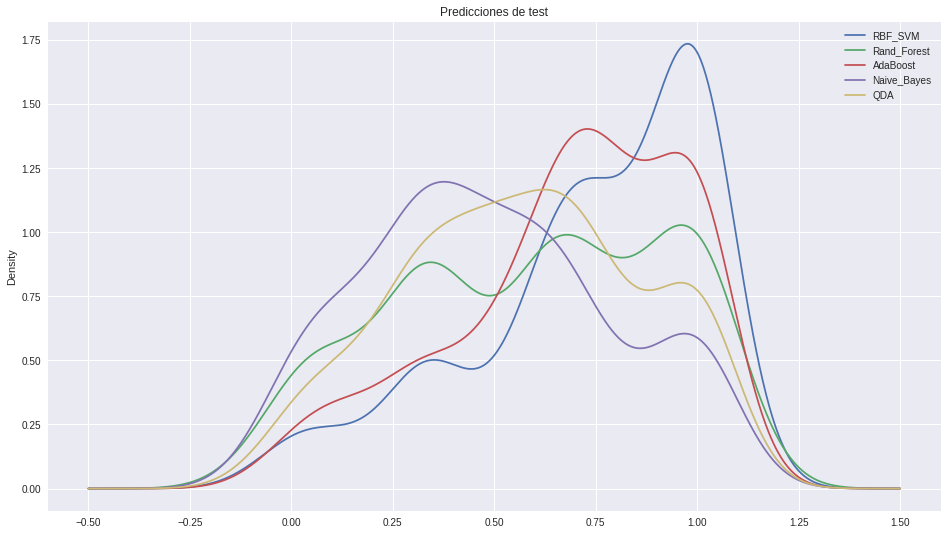

In [178]:
general_results.iloc[:,6:].plot.density(figsize=(16,9), title="Predicciones de test")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff314156a90>,
      dtype=object)

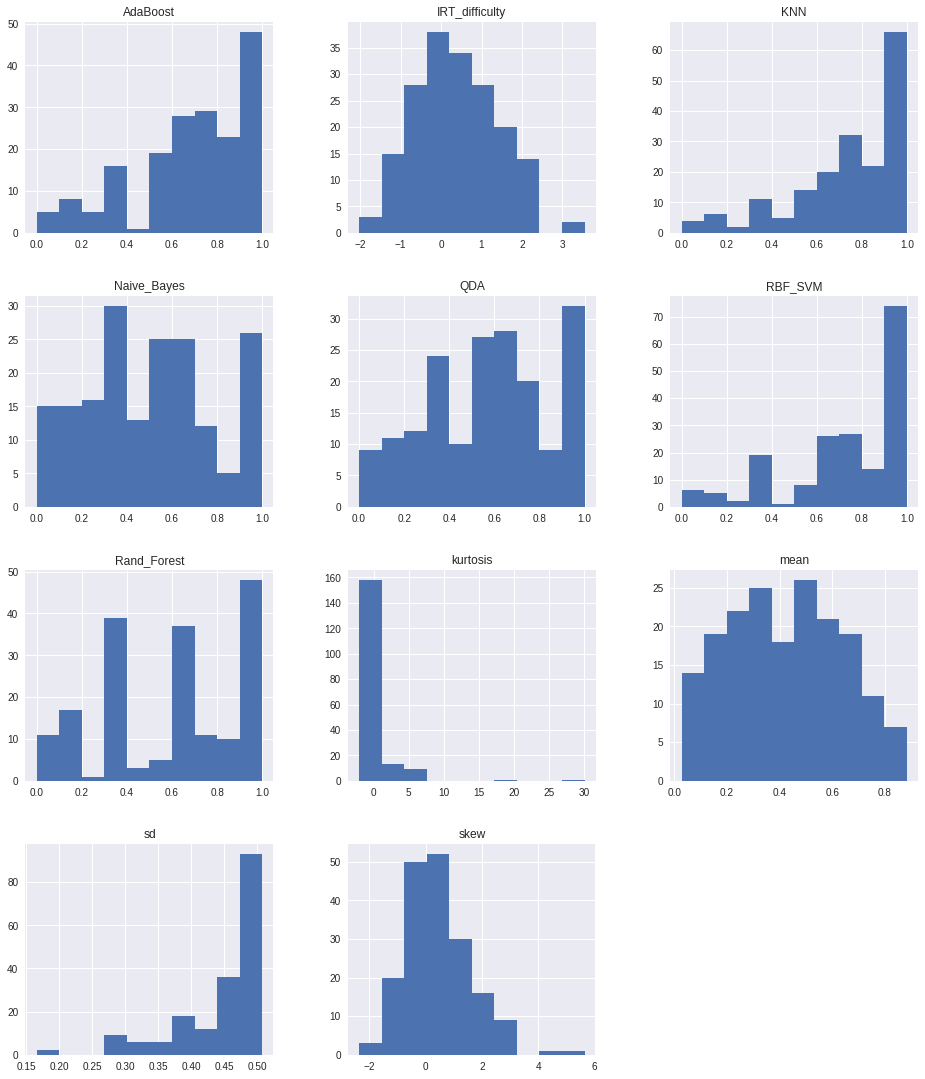

In [179]:
general_results.hist(figsize=(16,19))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff3117b6a20>,
      dtype=object)

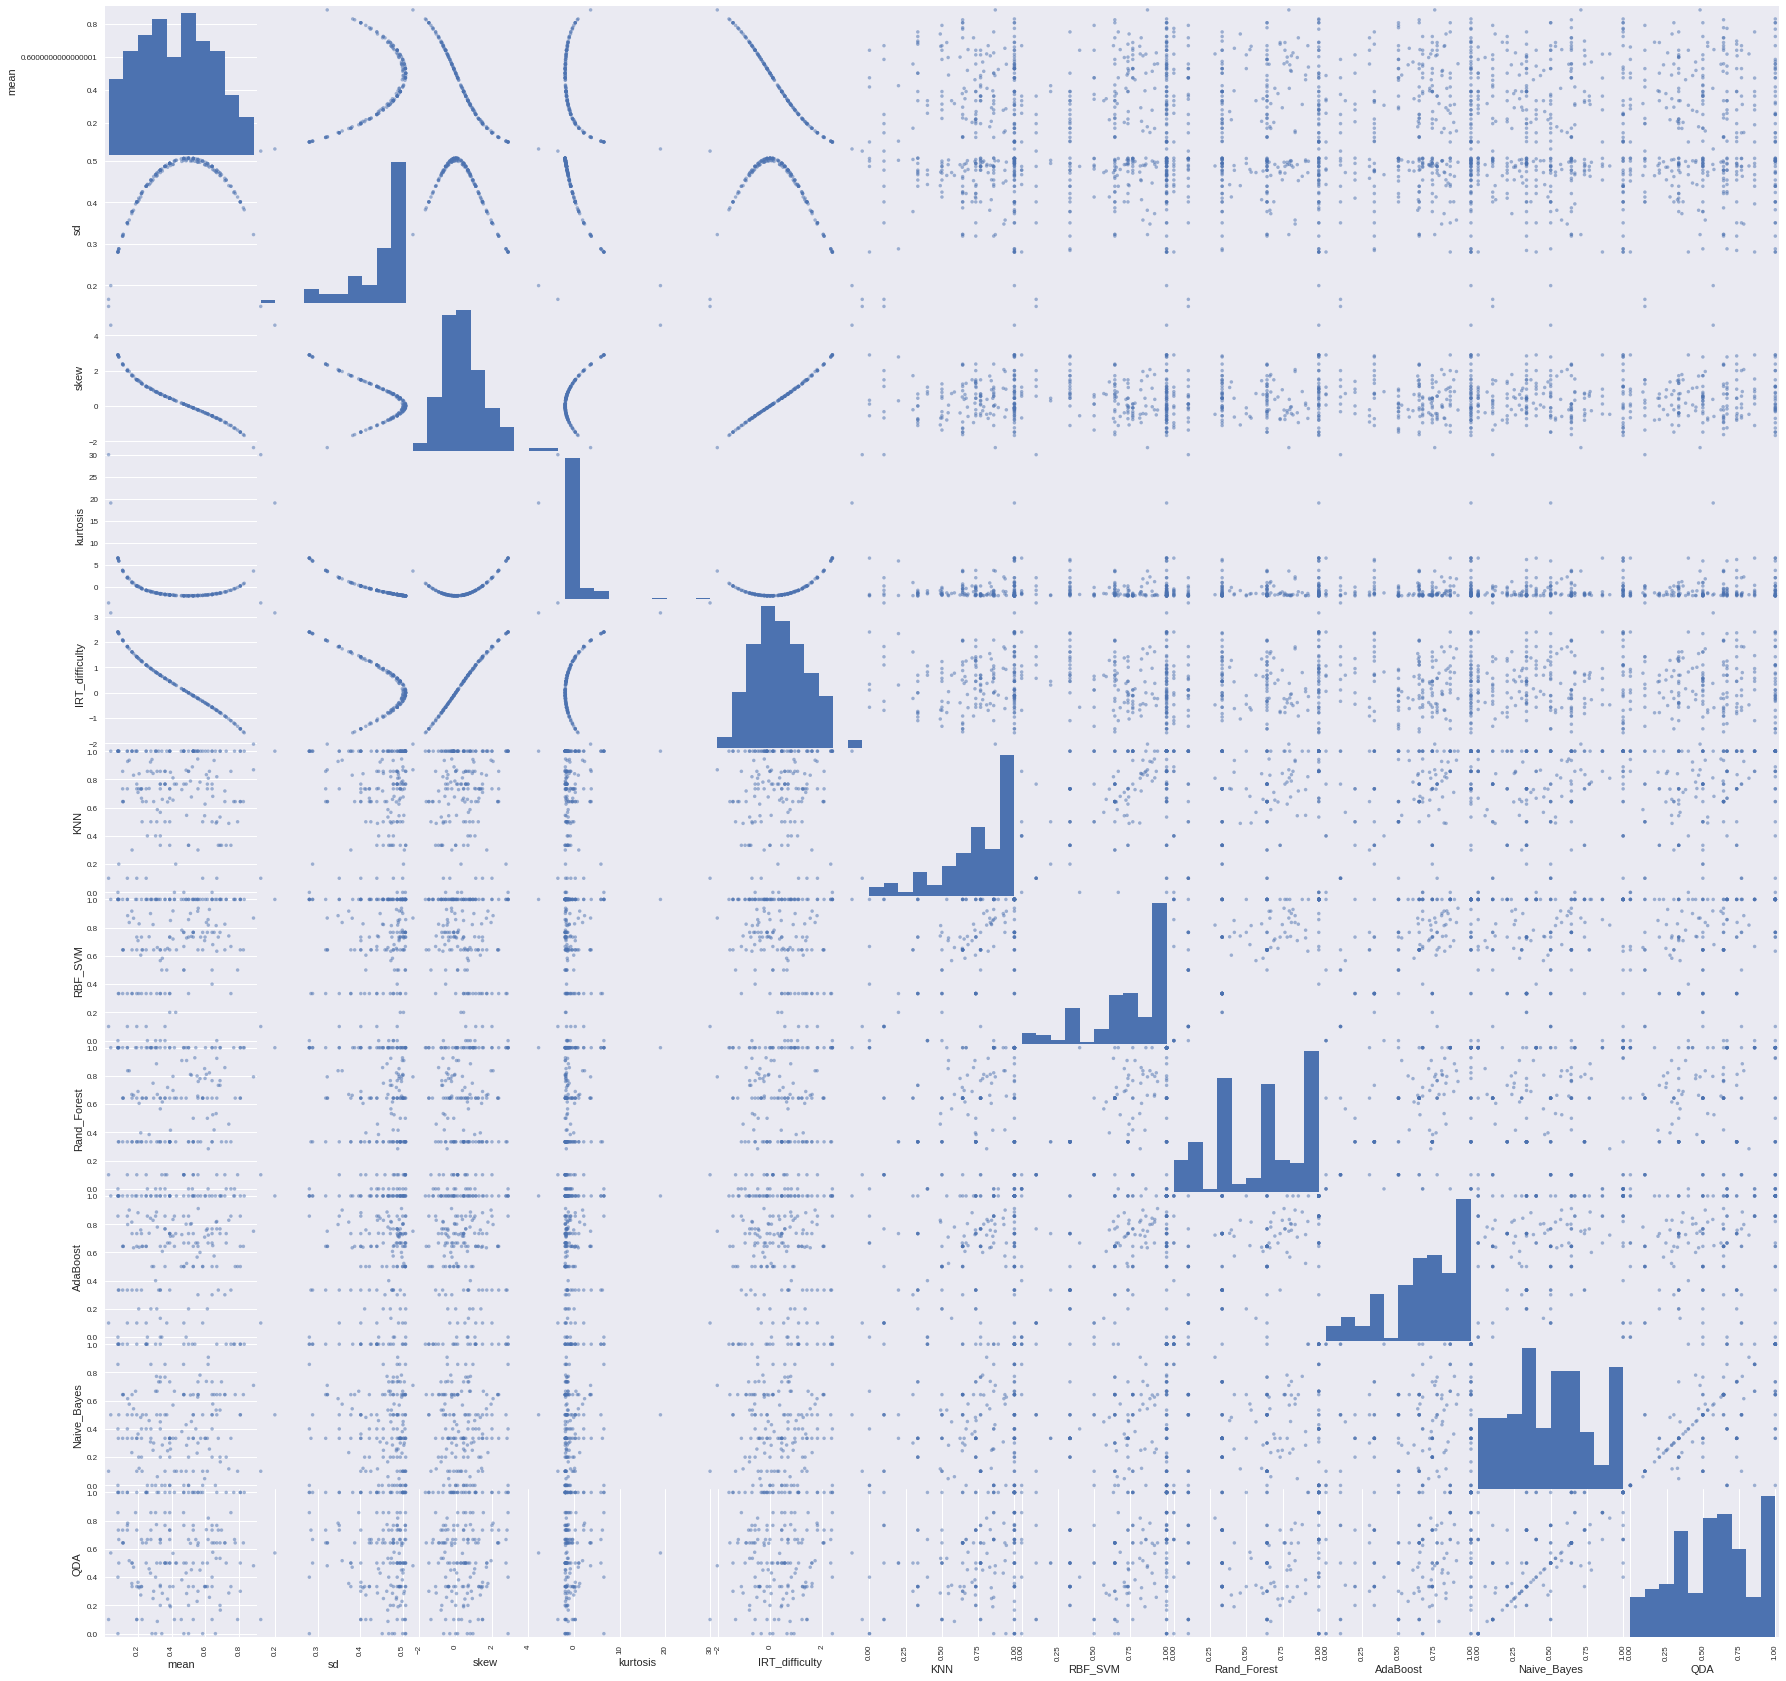

In [184]:
pd.plotting.scatter_matrix(general_results, figsize=(30,30))

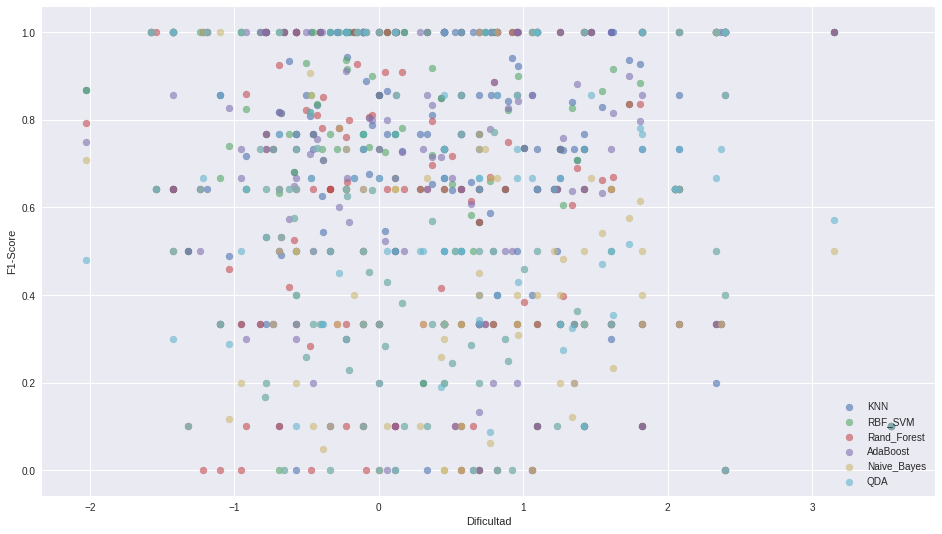

In [181]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(1, 1, 1)

for pred in predictors:
  x_vals=general_results.loc[:,"IRT_difficulty"]
  y_vals=general_results.loc[:,pred]
  ax.scatter(x=x_vals,
             y=y_vals,
             alpha=.6, label=pred)
plt.legend(loc='lower right')
plt.xlabel("Dificultad")
plt.ylabel("F1-Score")
plt.show()

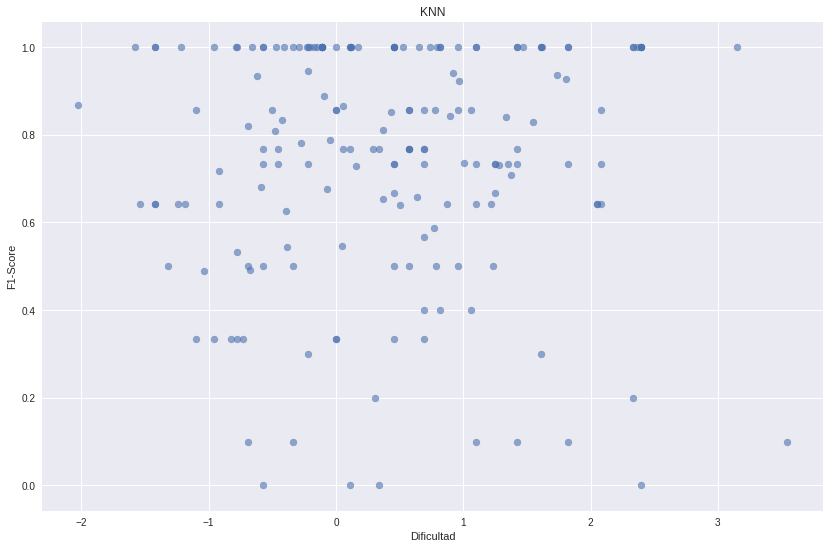

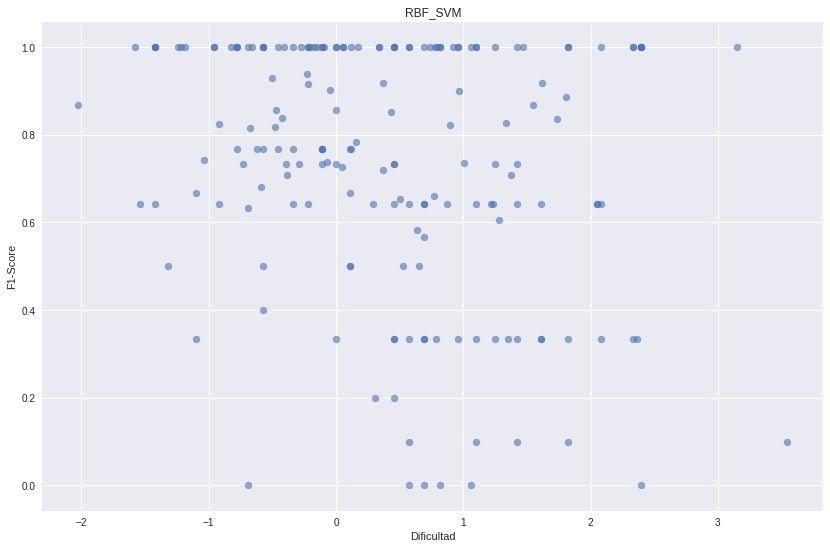

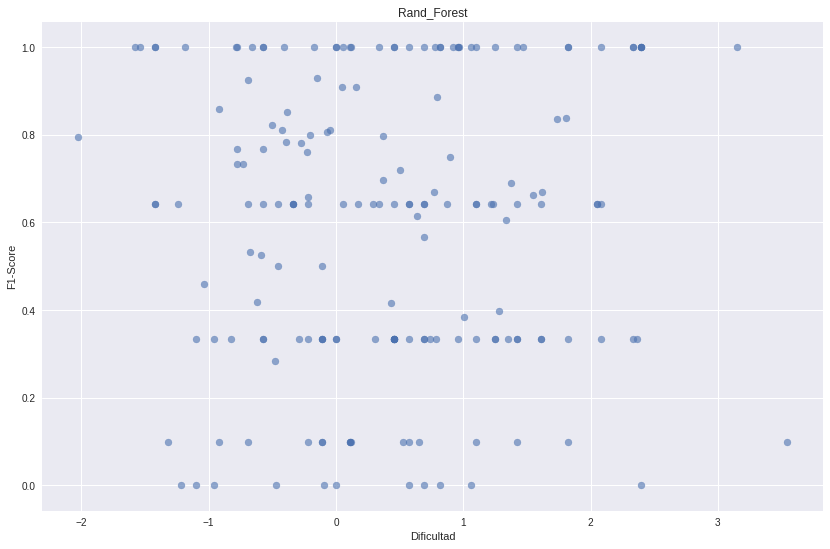

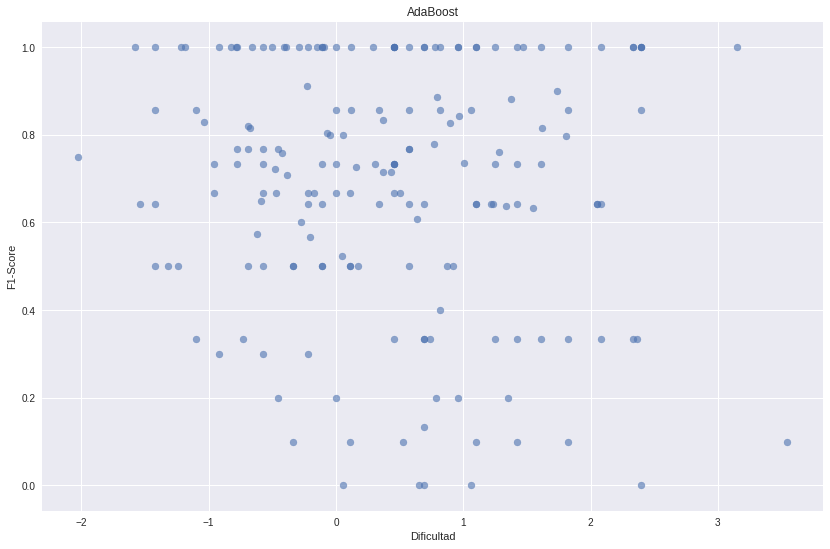

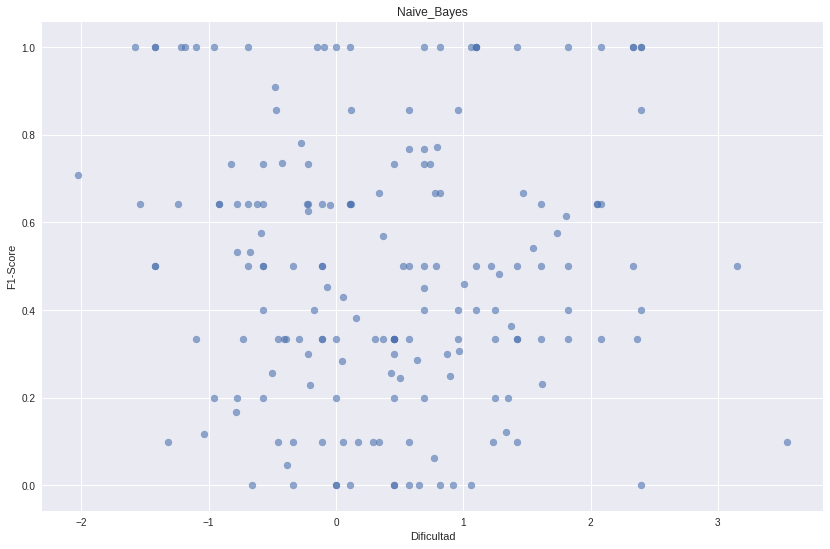

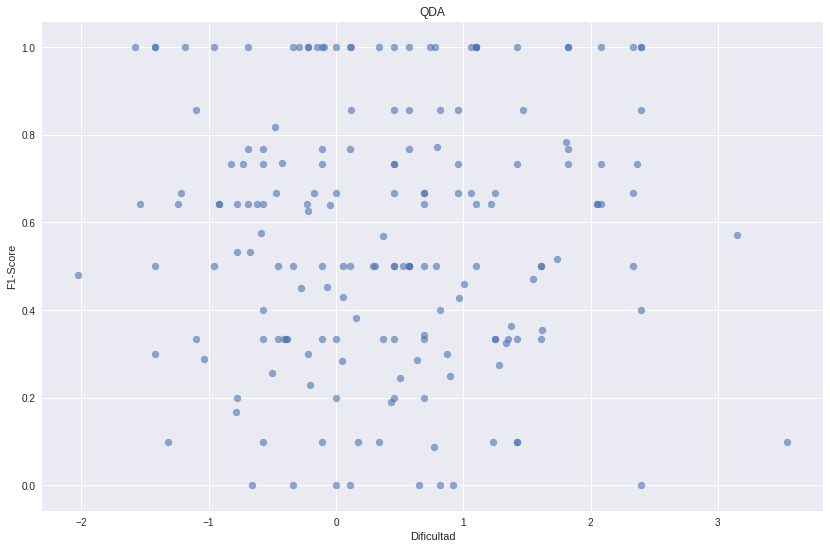

In [182]:
for pred in predictors:
  fig = plt.figure(figsize=(14,9))#16,9))
  ax = fig.add_subplot(1, 1, 1)

  x_vals=general_results.loc[:,"IRT_difficulty"]
  y_vals=general_results.loc[:,pred]
  ax.scatter(x=x_vals,
             y=y_vals,
             alpha=.6, label=pred)
  
#   plt.legend(loc='lower right')
  plt.xlabel("Dificultad")
  plt.ylabel("F1-Score")
  plt.title(pred)
  plt.show()